###  Topics

* Hadamard product
* matrix addition
* padding basic example
* rnn architectures
* rnn stepwise
    * bi-directional rnn
    * gru
    * lstm

In [2]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
from torch import nn

from torch import Tensor, dot, matmul

import torch.nn.functional as F

In [ ]:
# matrix multiplication

a=torch.tensor([1,2])
b=torch.tensor([4,5])

torch.matmul(a,b), a@b, torch.dot(a,b)

In [ ]:
# pointwise matrix multiplication (Hadamard product)

a*b

In [ ]:
a=torch.tensor([[1,2],[1,2]])
b=torch.tensor([[2,1],[2,1]])

print(a.view(-1,2),"\n\n")
print(b.view(-1,2))

In [ ]:
print(a@b)

In [ ]:
print(a*b)

In [ ]:
# e.g. in RNN we add matrices

a+b

In [ ]:
from torch.nn.utils.rnn import pad_sequence

a = [torch.tensor([1,2,3]), torch.tensor([3,4])]
b = torch.nn.utils.rnn.pad_sequence(a, batch_first=True)
b

# torch.nn.utils.rnn.pack_padded_sequence(b, batch_first=True, lengths=[3,2])

## RNN by example


In [4]:
seq = Tensor([[1,1,1],[1,2,1],[2,3,1], [1,3,1]])

seq = seq.unsqueeze(0)

seq.shape

torch.Size([1, 4, 3])

The `seq` variable represents a sequence of length 4, where each element (time-stamp) is represented by a feature vector of length 3.

Below we define a RNN layer where we set `input_size` to be 3. We also set `bias` to be True, so that we include a bias term in our calculations

## RNN architectures

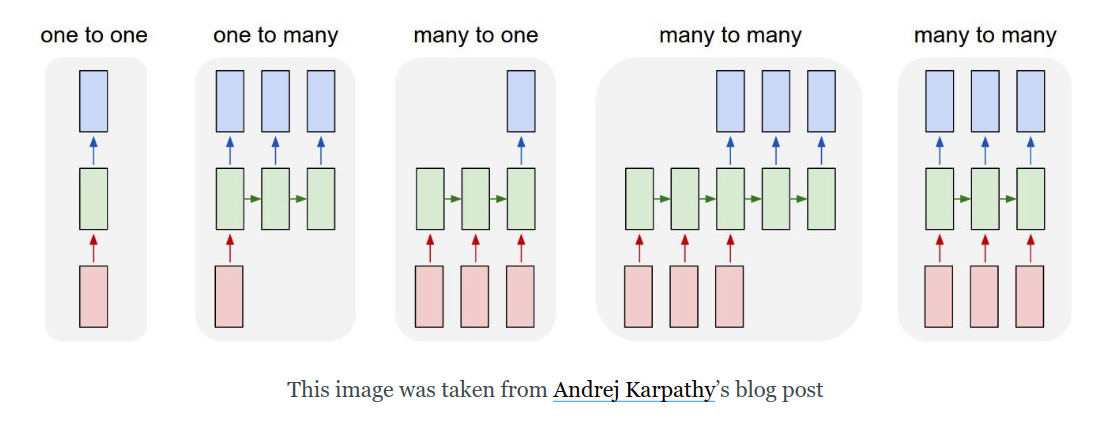

### Encoder - Decoder 

used e.g. in machine translation  (**join the course of Rico Sennrich in the Spring semester 2021!!!**)

* can handle inputs and outputs that are both variable-length sequences
* suitable for machine translation
* encoder produces a state with a fixed shape from a variable-length sequence
* decoder maps fixed shape to variable-length output
* input and output length thus can vary


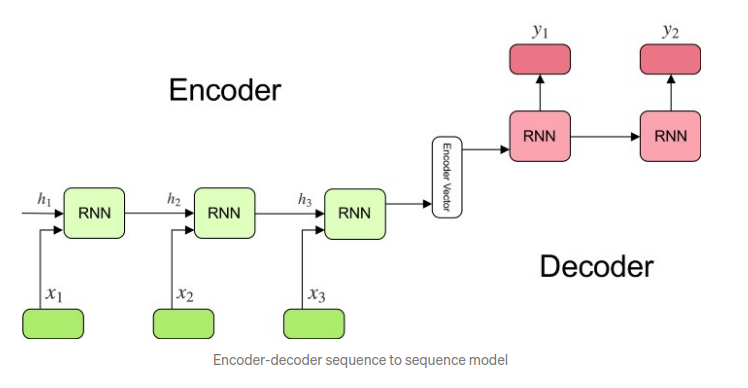

## **Building a Bi-Directional RNN**

In [ ]:
# Defining the RNN layer
rnn= nn.RNN(input_size=3, hidden_size=2, num_layers = 1, bias = True, batch_first=True, bidirectional=True)

In [ ]:
out_all, out_last = rnn(seq)

print(f"Out all shape : {out_all.shape}")

print(f"Out last shape : {out_last.shape}")

In [ ]:
out_all

In [ ]:
out_last

In [ ]:
rnn.state_dict()

### **Computing outputs - Forward Direction** 

For a bidirectional RNN layer with a hidden layer size of 2 and an input sequence of length 4, we get an output of size 4x4.

In the output, each row essentially captures the hidden state corresponding to a given time-stamp. In the previous example, each time stamp was represented by a vector of length 2 (because `hidden_size` = 2). Now, since its bidirectional, each hidden state is represented by a vector of length 4 ( 2 + 2)


For each timestamp, the first 2 values correspond to the forward run of the RNN and the last 2 values correspond to the backward run of the RNN.

In [ ]:
out_all

#### Hidden State 1 - Forward Direction

In [ ]:
wih = rnn.weight_ih_l0
whh = rnn.weight_hh_l0

bih = rnn.bias_ih_l0
bhh = rnn.bias_hh_l0

# We represent all reverse weights using a '_' suffix
wih_ = rnn.weight_ih_l0_reverse
whh_ = rnn.weight_hh_l0_reverse

bih_ = rnn.bias_ih_l0_reverse
bhh_ = rnn.bias_hh_l0_reverse

x = seq[0][0] # The first input feature of the first sequence

# Computing thw hidden state for time = 1
h1 = torch.tanh(Tensor(matmul(x,wih.T) + bih  + matmul( torch.zeros([1,2]) , whh.T ) + bhh))  
h1

#### Computing all states - Forward Direction

In [ ]:
output = []

h_previous = torch.zeros([1,2])  # Since the hidden_size parameter is 2, all hidden states will have a shape of [1,2]

for i in range(seq.shape[1]):

  x = seq[0][i]
  h_current = torch.tanh(Tensor(matmul(x,wih.T) + bih  + matmul(h_previous,whh.T) + bhh))
  h_previous = h_current
  output.append(h_current)


output

At this stage, we can compare the computed hidden states with the RNN layer output `out_all`. We can observe that computed states match to the first 2 elements of all the RNN layer outputs

In [ ]:
out_all[:,:,:2]

### **Computing Outputs - Backward Direction**

#### Hidden State 1 - Backward direction

In [ ]:
x = seq[0][-1] # The very last element of the sequence is now treated as the first element in the backward run

# Computing thw hidden state for time = 4
h4_ = torch.tanh(Tensor(matmul(x,wih_.T) + bih_  + matmul( torch.zeros([1,2]) , whh_.T ) + bhh_))  
h4_


#### Hidden State 2 - Backward direction

In [ ]:
x = seq[0][-2] 

# Computing thw hidden state for time = 3
h3_ = torch.tanh(Tensor(matmul(x,wih_.T) + bih_  + matmul( h4_ , whh_.T ) + bhh_))  
h3_


#### Hidden State 3 - Backward direction

In [ ]:
x = seq[0][-3] 

# Computing thw hidden state for time = 3
h2_ = torch.tanh(Tensor(matmul(x,wih_.T) + bih_  + matmul( h3_ , whh_.T ) + bhh_))  
h2_


#### Hidden State 4 - Backward direction

In [ ]:
x = seq[0][-4] 

# Computing thw hidden state for time = 3
h1_ = torch.tanh(Tensor(matmul(x,wih_.T) + bih_  + matmul( h2_ , whh_.T ) + bhh_))  
h1_


In [ ]:
output_ = [h1_,h2_,h3_,h4_]
output_

In [ ]:
out_all[:,:,2:]   #Checking only the 2nd half of the RNN layer output

The final RNN layer output is the concatentation of hidden states from both the forward and backward runs. On doing so, we can compare our manually computed results with the RNN layer output

In [ ]:
fullOutput = [ torch.cat( (output[i], output_[i]),1)  for i in range(4) ]

In [ ]:
fullOutput

In [ ]:
out_all

## **Expanding to GRUs**

In [ ]:
# Defining a basic GRU layer
gru = nn.GRU(input_size=3, hidden_size=1, num_layers = 1, bias = True, batch_first=True)

\begin{array}{ll}
 |          r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
 |          z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
 |          n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
 |          h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
 |      \end{array}

In [ ]:
gru.state_dict()

In [ ]:
out_all, out_last = gru(seq)

print(f"Out all shape : {out_all.shape}")

print(f"Out last shape : {out_last.shape}")

### Extracting layer weights

In [ ]:
wir_10 = gru.weight_ih_l0[0,:].squeeze(0)
wiz_10 = gru.weight_ih_l0[1,:].squeeze(0)
win_10 = gru.weight_ih_l0[2,:].squeeze(0)

whr_10 = gru.weight_hh_l0[0]
whz_10 = gru.weight_hh_l0[1]
whn_10 = gru.weight_hh_l0[2]

bir_10 = gru.bias_ih_l0[0]
biz_10 = gru.bias_ih_l0[1]
bin_10 = gru.bias_ih_l0[2]

bhr_10 = gru.bias_hh_l0[0]
bhz_10 = gru.bias_hh_l0[1]
bhn_10 = gru.bias_hh_l0[2]

### **Computing outputs**

#### Hidden State 1

In [ ]:
x = seq[0][0]

h_previous = torch.Tensor([0.0])

r = torch.sigmoid(dot(x,wir_10) + bir_10  + dot(h_previous,whr_10) + bhr_10  )
z = torch.sigmoid(dot(x,wiz_10) + biz_10  + dot(h_previous,whz_10) + bhz_10  )
n = torch.tanh(   dot(x,win_10) + bin_10  + r*( dot(h_previous,whn_10) + bhn_10) )
h1 = (1-z)*n + z*h_previous

h1

#### Hidden State 2

In [ ]:
x = seq[0][1]

h_previous = h1

r = torch.sigmoid(dot(x,wir_10) + bir_10  + dot(h_previous,whr_10) + bhr_10  )
z = torch.sigmoid(dot(x,wiz_10) + biz_10  + dot(h_previous,whz_10) + bhz_10  )
n = torch.tanh(   dot(x,win_10) + bin_10  + r*( dot(h_previous,whn_10) + bhn_10) )
h2 = (1-z)*n + z*h_previous

h2

#### Hidden State 3

In [ ]:
x = seq[0][2]

h_previous = h2

r = torch.sigmoid(dot(x,wir_10) + bir_10  + dot(h_previous,whr_10) + bhr_10  )
z = torch.sigmoid(dot(x,wiz_10) + biz_10  + dot(h_previous,whz_10) + bhz_10  )
n = torch.tanh(   dot(x,win_10) + bin_10  + r*( dot(h_previous,whn_10) + bhn_10) )
h3 = (1-z)*n + z*h_previous

h3

In [ ]:
out_all

In [ ]:
# repeated

seq = Tensor([[1,1,1],[1,2,1],[2,3,1], [1,3,1]])

seq = seq.unsqueeze(0)

## **Extending to LSTMs**

In [14]:
# Defining a basic LSTM layer
lstm = nn.LSTM(input_size=3, hidden_size=1, num_layers = 1, bias = True, batch_first=True)

\begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
 |          c_t = f_t * c_{(t-1)} + i_t * g_t \\
 |          h_t = o_t * \tanh(c_t) \\
 |      \end{array}

In [15]:
lstm.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.2369, -0.4977,  0.6606],
                      [-0.4456,  0.8957, -0.9133],
                      [ 0.4734, -0.6945, -0.5896],
                      [-0.5590, -0.8931,  0.2517]])),
             ('weight_hh_l0',
              tensor([[ 0.7293],
                      [ 0.7462],
                      [ 0.9917],
                      [-0.0738]])),
             ('bias_ih_l0', tensor([ 0.1982,  0.9103, -0.1366, -0.7844])),
             ('bias_hh_l0', tensor([-0.0242, -0.2399,  0.6688, -0.3041]))])

In [16]:
out_all, out_last = lstm(seq)

print(f"Out all shape : {out_all.shape}")

print(f"Out last shape : {out_last[0].shape}")

Out all shape : torch.Size([1, 4, 1])
Out last shape : torch.Size([1, 1, 1])


In [17]:
out_last   # last (hidden,cell) state

(tensor([[[-0.0132]]], grad_fn=<StackBackward>),
 tensor([[[-1.0776]]], grad_fn=<StackBackward>))

In [18]:
out_all

tensor([[[-0.0158],
         [-0.0191],
         [-0.0064],
         [-0.0132]]], grad_fn=<TransposeBackward0>)

### Extracting weights

In [19]:
wii_10 = lstm.weight_ih_l0[0,:].squeeze(0)
wif_10 = lstm.weight_ih_l0[1,:].squeeze(0)
wig_10 = lstm.weight_ih_l0[2,:].squeeze(0)
wio_10 = lstm.weight_ih_l0[3,:].squeeze(0)

whi_10 = lstm.weight_hh_l0[0]
whf_10 = lstm.weight_hh_l0[1]
whg_10 = lstm.weight_hh_l0[2]
who_10 = lstm.weight_hh_l0[3]

bii_10 = lstm.bias_ih_l0[0]
bif_10 = lstm.bias_ih_l0[1]
big_10 = lstm.bias_ih_l0[2]
bio_10 = lstm.bias_ih_l0[3]

bhi_10 = lstm.bias_hh_l0[0]
bhf_10 = lstm.bias_hh_l0[1]
bhg_10 = lstm.bias_hh_l0[2]
bho_10 = lstm.bias_hh_l0[3]

wif_10,lstm.state_dict()

(tensor([-0.4456,  0.8957, -0.9133], grad_fn=<SqueezeBackward1>),
 OrderedDict([('weight_ih_l0',
               tensor([[ 0.2369, -0.4977,  0.6606],
                       [-0.4456,  0.8957, -0.9133],
                       [ 0.4734, -0.6945, -0.5896],
                       [-0.5590, -0.8931,  0.2517]])),
              ('weight_hh_l0',
               tensor([[ 0.7293],
                       [ 0.7462],
                       [ 0.9917],
                       [-0.0738]])),
              ('bias_ih_l0', tensor([ 0.1982,  0.9103, -0.1366, -0.7844])),
              ('bias_hh_l0', tensor([-0.0242, -0.2399,  0.6688, -0.3041]))]))

## **Computing output**

\begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
 |          c_t = f_t * c_{(t-1)} + i_t * g_t \\
 |          h_t = o_t * \tanh(c_t) \\
 |      \end{array}

#### Hidden State 1

In [20]:
x = seq[0][0]

h_previous = torch.Tensor([0.0])
c_previous = torch.Tensor([0.0])

i = torch.sigmoid(dot(x,wii_10) + bii_10  + dot(h_previous,whi_10) + bhi_10  )
f = torch.sigmoid(dot(x,wif_10) + bif_10  + dot(h_previous,whf_10) + bhf_10  )
g = torch.tanh(   dot(x,wig_10) + big_10  + dot(h_previous,whg_10) + bhg_10  )
o = torch.sigmoid(dot(x,wio_10) + bio_10  + dot(h_previous,who_10) + bho_10  )
c1 = f* c_previous + i*g
h1 = o* torch.tanh(c1)

h1

tensor([-0.0158], grad_fn=<MulBackward0>)

#### Hidden State 2

In [22]:
x = seq[0][1]

h_previous = h1
c_previous = c1

i = torch.sigmoid(dot(x,wii_10) + bii_10  + dot(h_previous,whi_10) + bhi_10  )
f = torch.sigmoid(dot(x,wif_10) + bif_10  + dot(h_previous,whf_10) + bhf_10  )
g = torch.tanh(   dot(x,wig_10) + big_10  + dot(h_previous,whg_10) + bhg_10  )
o = torch.sigmoid(dot(x,wio_10) + bio_10  + dot(h_previous,who_10) + bho_10  )
c2 = f* c_previous + i*g
h2 = o* torch.tanh(c2)

h2

tensor([-0.0191], grad_fn=<MulBackward0>)

In [21]:
out_all

tensor([[[-0.0158],
         [-0.0191],
         [-0.0064],
         [-0.0132]]], grad_fn=<TransposeBackward0>)

In [ ]:
help(nn.LSTM)

In [ ]:
help(gru)